In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pattrex.plotting_mpl as plt_rex
import pattrex.preprocessing as pre_rex

from pattrex.demo_helper import read_whdata

In [6]:
# Read data, remove and save outliers
ws, hs, gs = read_whdata()
HW = np.vstack((hs, ws)).astype(np.float)
HW_new, neg_idx = pre_rex.only_all_positive(HW, True, return_neg_idx=True)
H_unknown = np.array([h for i, h in enumerate(hs) if i in neg_idx])

hn = HW_new[0, :]
wn = HW_new[1, :]

## Bayesian Regression ala `sklearn`

In [5]:
from sklearn.linear_model import BayesianRidge

In [8]:
from numpy.polynomial.polynomial import polyvander

In [124]:
d = 5

hnv = polyvander(hn, d)

In [144]:
clf = BayesianRidge(verbose=True)
clf.fit(hnv, wn)

Convergence after  3  iterations


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=True)

In [126]:
W = clf.coef_
W

array([  0.00000000e+00,  -8.58396734e-09,  -1.46782148e-06,
        -1.25505530e-04,   1.43678494e-06,  -3.75820142e-09])

In [127]:
huv = polyvander(H_unknown, d)

In [128]:
w_pred = clf.predict(huv)
w_pred

array([ 62.41376747,  69.04774152,  60.76112354])

In [160]:
clf.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'n_iter': 300,
 'normalize': False,
 'tol': 0.001,
 'verbose': True}

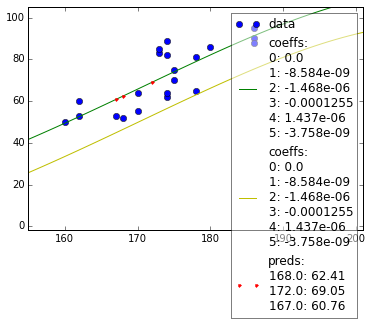

In [99]:
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
HW_ = np.vstack((hs, ws))  # only the measurements; data is col-wise
xmin, ymin = HW_.min(axis=1)
xmax, ymax = HW_.max(axis=1)

xlim = [xmin-5, xmax+15]  # purely for looks
ylim = [-2, ymax+10]

# generate data for the fitted solution
h = np.linspace(hn.min()-5, hn.max()+15)
h_ = polyvander(h, d)
w = clf.predict(h_)

ww = np.dot(h_, W)

plt_rex.plot2d(HW_new, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
               show=False, axs=axs, plotlabel="data")

plt_label = "coeffs:\n" + "\n".join("{}: {:.4}".format(*c) for c in enumerate(W))
plt_rex.plot2d(np.vstack((h, w)), colwise_data=True, hatch='g', 
               show=False, axs=axs, plotlabel=plt_label)

plt_rex.plot2d(np.vstack((h, ww)), colwise_data=True, hatch='y', 
               show=False, axs=axs, plotlabel=plt_label)

plt_label = "preds:\n" + "\n".join("{}: {:.4}".format(*c) for c in zip(H_unknown, w_pred))
plt_rex.plot2d(np.vstack((H_unknown, w_pred)), colwise_data=True, hatch='r.', 
               show=False, axs=axs, plotlabel=plt_label)

***

In [60]:
x = np.random.uniform(-5, 5, 100)
y = np.power(x, 2) + np.random.uniform(-0.5, 0.5, 100)
x = np.hstack((x, np.array([0.1, 0.2])))
y = np.hstack((y, np.array([10, 15])))

In [61]:
clff = BayesianRidge()
x_ = polyvander(x, 5)

clff.fit(x_, y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [62]:
clff.coef_

array([  0.00000000e+00,   1.55387000e-01,   8.36027832e-01,
        -1.98701332e-02,   5.69918013e-03,   5.98225436e-04])

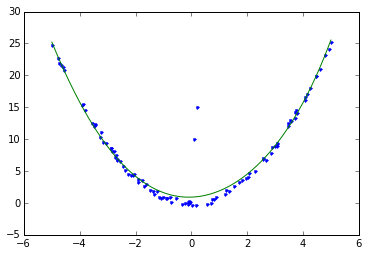

In [63]:
plt.plot(x, y, '.')

xx = np.linspace(-5, 5, 200)
xx_ = polyvander(xx, 5)
yy = clff.predict(xx_)

plt.plot(xx, yy)

## On our own

In [202]:
d = 5
x = np.copy(hn)
X = polyvander(x, d)

y = np.copy(wn)

In [203]:
sig2 = np.var(y)

sig2_0 = 3
mu_0 = 0

XtX = np.dot(np.transpose(X), X)
XtX

array([[  2.10000000e+01,   3.64500000e+03,   6.33769000e+05,
          1.10386503e+08,   1.92596430e+10,   3.36606873e+12],
       [  3.64500000e+03,   6.33769000e+05,   1.10386503e+08,
          1.92596430e+10,   3.36606873e+12,   5.89297930e+14],
       [  6.33769000e+05,   1.10386503e+08,   1.92596430e+10,
          3.36606873e+12,   5.89297930e+14,   1.03342326e+17],
       [  1.10386503e+08,   1.92596430e+10,   3.36606873e+12,
          5.89297930e+14,   1.03342326e+17,   1.81529253e+19],
       [  1.92596430e+10,   3.36606873e+12,   5.89297930e+14,
          1.03342326e+17,   1.81529253e+19,   3.19398807e+21],
       [  3.36606873e+12,   5.89297930e+14,   1.03342326e+17,
          1.81529253e+19,   3.19398807e+21,   5.62899631e+23]])

In [204]:
print(sig2)

209.011337868


In [205]:
Prec = (1/sig2) * XtX + (1/sig2_0) * np.eye(d+1)
Prec

array([[  4.33806352e-01,   1.74392453e+01,   3.03222307e+03,
          5.28136436e+05,   9.21464030e+07,   1.61047184e+10],
       [  1.74392453e+01,   3.03255640e+03,   5.28136436e+05,
          9.21464030e+07,   1.61047184e+10,   2.81945437e+12],
       [  3.03222307e+03,   5.28136436e+05,   9.21464033e+07,
          1.61047184e+10,   2.81945437e+12,   4.94434066e+14],
       [  5.28136436e+05,   9.21464030e+07,   1.61047184e+10,
          2.81945437e+12,   4.94434066e+14,   8.68513904e+16],
       [  9.21464030e+07,   1.61047184e+10,   2.81945437e+12,
          4.94434066e+14,   8.68513904e+16,   1.52814106e+19],
       [  1.61047184e+10,   2.81945437e+12,   4.94434066e+14,
          8.68513904e+16,   1.52814106e+19,   2.69315357e+21]])

In [206]:
mu = (1/sig2) * np.dot(np.linalg.pinv(Prec), np.dot(np.transpose(X), y))
mu

array([ -1.90109772e-10,  -1.97395524e-08,  -1.70906136e-06,
        -9.87458994e-05,   1.21689161e-06,  -3.27789493e-09])

In [210]:
w_map = np.dot(np.linalg.pinv(XtX + (sig2/sig2_0) * np.eye(d+1)), 
               np.dot(np.transpose(X), y))

w_map

array([ -1.90109772e-10,  -1.97345627e-08,  -1.70906136e-06,
        -9.87458994e-05,   1.21689161e-06,  -3.27789493e-09])

In [208]:
w_map2 = np.dot(np.dot(np.linalg.inv(XtX + (sig2/sig2_0) * np.eye(d+1)), 
               np.transpose(X)), y)

w_map2

array([  1.75403490e-04,   8.64614411e-03,   3.63943932e-01,
        -6.39907782e-03,   3.75122803e-05,  -7.28705301e-08])

In [211]:
import scipy.sparse.linalg as sla

w_map3 = sla.lsmr(X, y, damp=(sig2/sig2_0))
w_map3

(array([  4.56663105e-16,   6.41471521e-14,   8.46043977e-12,
          9.93344809e-10,   8.75977569e-08,  -5.48878150e-11]),
 2,
 2,
 39.06160933154306,
 804293.24618307676,
 750278470980.438,
 4353.7301832225294,
 8.7603406459642545e-08)

In [181]:
from scipy.stats import norm

[ 62.32323232  68.88888889  61.01010101]


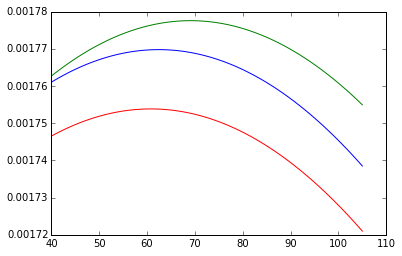

In [198]:
w_pred2 = []

mu_t = np.transpose(mu)
Prec_inv = np.linalg.pinv(Prec)
for hu in H_unknown:
    huv = np.transpose(polyvander(hu, d))
    
    mean = np.dot(mu_t, huv)
    sigma = sig2 + np.dot(np.transpose(huv), np.dot(Prec_inv, huv))
    
    y = np.linspace(wn.min()-10, wn.max()+10, 100)
    pdf = np.transpose(norm.pdf(y, mean, sigma))
    
    plt.plot(y, pdf)
    
    w_pred2.append(y[np.argmax(pdf)])
    
w_pred2 = np.array(w_pred2)
print(w_pred2)

In [199]:
def predict(huv_):
    w_pred2 = []
    for hu in huv_:
        huv = np.transpose(hu)

        mean = np.dot(mu_t, huv)
        sigma = sig2 + np.dot(np.transpose(huv), np.dot(Prec_inv, huv))

        y = np.linspace(wn.min()-10, wn.max()+10, 100)
        pdf = np.transpose(norm.pdf(y, mean, sigma))

        w_pred2.append(y[np.argmax(pdf)])
        
    return np.array(w_pred2)

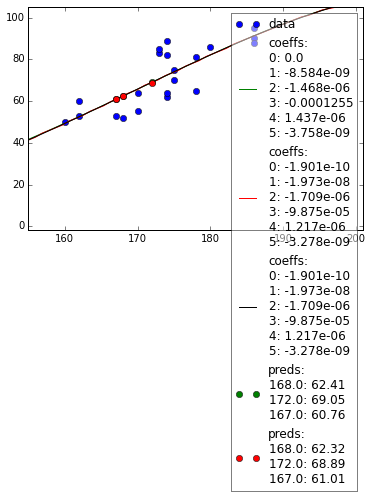

In [200]:
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
HW_ = np.vstack((hs, ws))  # only the measurements; data is col-wise
xmin, ymin = HW_.min(axis=1)
xmax, ymax = HW_.max(axis=1)

xlim = [xmin-5, xmax+15]  # purely for looks
ylim = [-2, ymax+10]

# generate data for the fitted solution
h = np.linspace(hn.min()-5, hn.max()+15)
h_ = polyvander(h, d)
w = clf.predict(h_)
w2 = predict(h_)

ww = np.dot(h_, np.transpose(W))
ww2 = np.dot(h_, np.transpose(w_map))

plt_rex.plot2d(HW_new, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
               show=False, axs=axs, plotlabel="data")

plt_label = "coeffs:\n" + "\n".join("{}: {:.4}".format(*c) for c in enumerate(W))
plt_rex.plot2d(np.vstack((h, w)), colwise_data=True, hatch='g', 
               show=False, axs=axs, plotlabel=plt_label)

plt_label = "coeffs:\n" + "\n".join("{}: {:.4}".format(*c) for c in enumerate(w_map))
plt_rex.plot2d(np.vstack((h, w2)), colwise_data=True, hatch='r', 
               show=False, axs=axs, plotlabel=plt_label)

# plt_rex.plot2d(np.vstack((h, ww)), colwise_data=True, hatch='y', 
#                show=False, axs=axs, plotlabel=plt_label)

plt_rex.plot2d(np.vstack((h, ww2)), colwise_data=True, hatch='k', 
               show=False, axs=axs, plotlabel=plt_label)


plt_label = "preds:\n" + "\n".join("{}: {:.4}".format(*c) for c in zip(H_unknown, w_pred))
plt_rex.plot2d(np.vstack((H_unknown, w_pred)), colwise_data=True, hatch='go', 
               show=False, axs=axs, plotlabel=plt_label)

plt_label = "preds:\n" + "\n".join("{}: {:.4}".format(*c) for c in zip(H_unknown, w_pred2))
plt_rex.plot2d(np.vstack((H_unknown, w_pred2)), colwise_data=True, hatch='ro', 
               show=False, axs=axs, plotlabel=plt_label)
